In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Lambda, Dense, Flatten, BatchNormalization, Conv2D, MaxPool2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator,load_img
from sklearn.metrics import confusion_matrix
import itertools
import os
import shutil
import random
from glob import glob
import matplotlib.pyplot as plt
from keras.callbacks import ModelCheckpoint

from keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input

In [2]:
def count_files_in_folders(folder_path):
    # Initialize counters
    total_files = 0

    # Walk through the folder and its subfolders
    for root, dirs, files in os.walk(folder_path):
        # Count files in the current folder
        files_count = len(files)
        total_files += files_count

        # Display the result for the current folder
        print(f"Folder: {root}, Files: {files_count}")

    # Display the total count
    print(f"\nTotal Files in {folder_path}: {total_files}")

# the path to analyze
folder_path = '/content/drive/MyDrive/Train_Ready'
count_files_in_folders(folder_path)


Folder: /content/drive/MyDrive/Train_Ready, Files: 0
Folder: /content/drive/MyDrive/Train_Ready/train, Files: 0
Folder: /content/drive/MyDrive/Train_Ready/train/healthy, Files: 1214
Folder: /content/drive/MyDrive/Train_Ready/train/leaf_blight, Files: 1222
Folder: /content/drive/MyDrive/Train_Ready/train/yellow_mottle_virus, Files: 1220
Folder: /content/drive/MyDrive/Train_Ready/validation, Files: 0
Folder: /content/drive/MyDrive/Train_Ready/validation/healthy, Files: 260
Folder: /content/drive/MyDrive/Train_Ready/validation/leaf_blight, Files: 262
Folder: /content/drive/MyDrive/Train_Ready/validation/yellow_mottle_virus, Files: 261
Folder: /content/drive/MyDrive/Train_Ready/test, Files: 0
Folder: /content/drive/MyDrive/Train_Ready/test/healthy, Files: 261
Folder: /content/drive/MyDrive/Train_Ready/test/leaf_blight, Files: 263
Folder: /content/drive/MyDrive/Train_Ready/test/yellow_mottle_virus, Files: 263

Total Files in /content/drive/MyDrive/Train_Ready: 5226


In [3]:
train_path = "/content/drive/MyDrive/Train_Ready/train"
valid_path = "/content/drive/MyDrive/Train_Ready/validation"
test_path = "/content/drive/MyDrive/Train_Ready/test"

In [4]:
train_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.vgg16.preprocess_input) \
  .flow_from_directory(directory=train_path, target_size=(224,224), classes=['healthy', 'leaf_blight', 'yellow_mottle_virus'], batch_size=32)
valid_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.vgg16.preprocess_input) \
  .flow_from_directory(directory=valid_path, target_size=(224,224), classes=['healthy', 'leaf_blight', 'yellow_mottle_virus'], batch_size=32)
test_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.vgg16.preprocess_input) \
  .flow_from_directory(directory=test_path, target_size=(224,224), classes=['healthy', 'leaf_blight', 'yellow_mottle_virus'], batch_size=32, shuffle=False)

Found 3656 images belonging to 3 classes.
Found 783 images belonging to 3 classes.
Found 787 images belonging to 3 classes.


In [6]:
assert train_batches.num_classes == valid_batches.num_classes == test_batches.num_classes == 3

In [7]:
imgs, labels = next(train_batches)

In [8]:
def plotImages(images_arr):
    fig, axes = plt.subplots(1, 5, figsize=(20, 20))
    axes = axes.flatten()
    for img, ax in zip(images_arr, axes):
        ax.imshow(img)
        ax.axis('off')
    plt.tight_layout()
    plt.show()

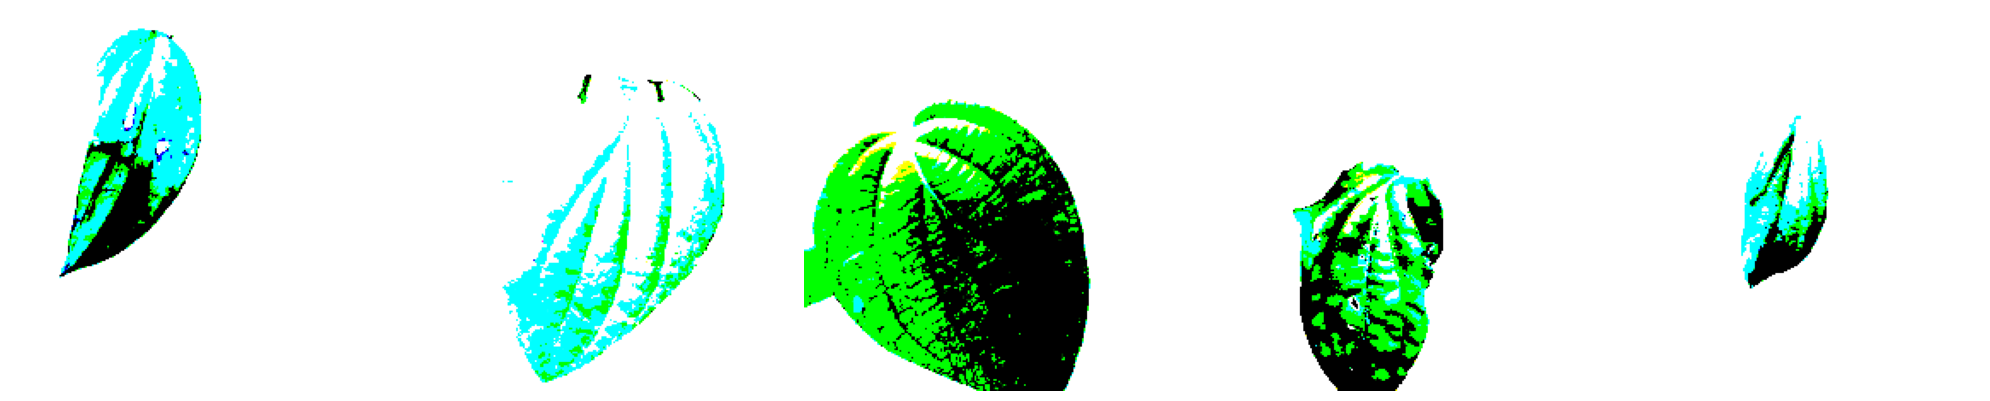

[[0. 1. 0.]
 [0. 1. 0.]
 [1. 0. 0.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 1. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [0. 0. 1.]
 [0. 0. 1.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 1. 0.]
 [0. 0. 1.]
 [0. 1. 0.]
 [0. 0. 1.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 0. 1.]
 [0. 1. 0.]
 [1. 0. 0.]
 [0. 0. 1.]
 [0. 1. 0.]
 [0. 0. 1.]
 [1. 0. 0.]
 [0. 0. 1.]]


In [9]:
plotImages(imgs)
print(labels)

In [10]:
vgg16_model = tf.keras.applications.vgg16.VGG16()

553467096/553467096 [==============================] - 4s 0us/step


In [11]:
vgg16_model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [12]:
model = Sequential()
for layer in vgg16_model.layers[:-1]:
  model.add(layer)

In [13]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0         
                                                                 
 block3_conv1 (Conv2D)       (None, 56, 56, 256)       2

In [14]:
for layer in model.layers:
  layer.trainable=False

In [15]:
model.add(Dense(units=3, activation='softmax'))

In [16]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0         
                                                                 
 block3_conv1 (Conv2D)       (None, 56, 56, 256)       2

In [17]:
# tell the model what cost and optimization method to use
model.compile(
  loss='categorical_crossentropy',
  optimizer=Adam(learning_rate=0.0001),
  metrics=['accuracy']
)

In [18]:
model_path = '/content/drive/MyDrive/Models/Trained_Models/VGG17MCR.h5'
checkpoint = ModelCheckpoint(model_path, monitor='val_accuracy', verbose=2, save_best_only=True, mode='max')
callbacks_list = [checkpoint]

In [19]:
# fit the model
# Run the cell. It will take some time to execute
history = model.fit(x=train_batches,
  validation_data=valid_batches,
  epochs=10,
  callbacks=callbacks_list
)

Epoch 1/10
115/115 [==============================] - ETA: 0s - loss: 0.7767 - accuracy: 0.6816
Epoch 1: val_accuracy improved from -inf to 0.90421, saving model to /content/drive/MyDrive/Models/Trained_Models/VGG17MCR.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


115/115 [==============================] - 1343s 12s/step - loss: 0.7767 - accuracy: 0.6816 - val_loss: 0.3060 - val_accuracy: 0.9042
Epoch 2/10
115/115 [==============================] - ETA: 0s - loss: 0.2392 - accuracy: 0.9357
Epoch 2: val_accuracy improved from 0.90421 to 0.94508, saving model to /content/drive/MyDrive/Models/Trained_Models/VGG17MCR.h5
115/115 [==============================] - 38s 320ms/step - loss: 0.2392 - accuracy: 0.9357 - val_loss: 0.1748 - val_accuracy: 0.9451
Epoch 3/10
115/115 [==============================] - ETA: 0s - loss: 0.1597 - accuracy: 0.9617
Epoch 3: val_accuracy improved from 0.94508 to 0.96296, saving model to /content/drive/MyDrive/Models/Trained_Models/VGG17MCR.h5
115/115 [==============================] - 32s 278ms/step - loss: 0.1597 - accuracy: 0.9617 - val_loss: 0.1322 - val_accuracy: 0.9630
Epoch 4/10
115/115 [==============================] - ETA: 0s - loss: 0.1234 - accuracy: 0.9718
Epoch 4: val_accuracy improved from 0.96296 to 0.970

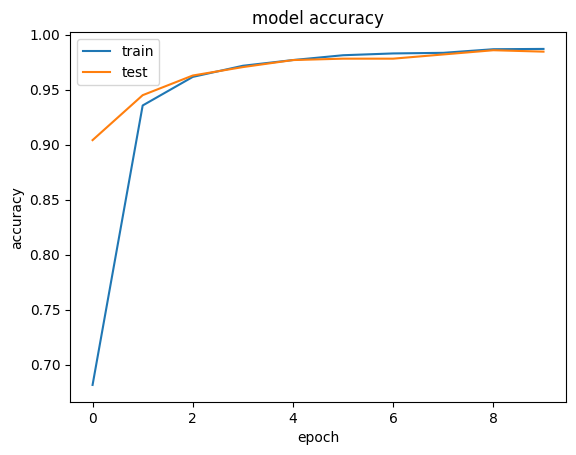

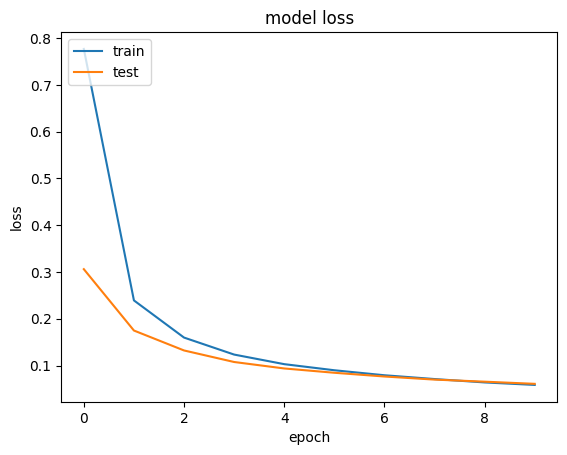

In [20]:
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [21]:
predictions = model.predict(x=test_batches, verbose=0)

In [22]:
test_batches.classes

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,

In [23]:
for i in predictions:
  print(i)

[0.15722266 0.02739963 0.81537765]
[0.9728581  0.01483124 0.01231056]
[0.9733123  0.0109668  0.01572086]
[0.9907409  0.00302266 0.00623645]
[9.9616301e-01 3.4089652e-03 4.2801860e-04]
[9.8178732e-01 1.7563591e-02 6.4908544e-04]
[0.97815186 0.02059478 0.00125335]
[9.9670780e-01 8.8238547e-04 2.4097867e-03]
[0.9560446  0.03504813 0.00890724]
[0.99465644 0.00195175 0.00339186]
[0.978734   0.01396529 0.00730071]
[9.9882454e-01 5.1196927e-04 6.6339981e-04]
[0.9323051  0.00419517 0.06349976]
[0.8719917  0.12068602 0.00732226]
[0.7749748  0.0080137  0.21701147]
[9.9202853e-01 7.1460516e-03 8.2542165e-04]
[0.78337044 0.07796078 0.13866876]
[0.9949033  0.00312152 0.00197521]
[9.9594325e-01 3.4229327e-03 6.3380628e-04]
[0.9971029  0.00130391 0.00159313]
[9.9784160e-01 1.2774917e-03 8.8088185e-04]
[0.9872471  0.00729285 0.0054601 ]
[0.98716563 0.01004722 0.00278706]
[9.9707687e-01 2.7441077e-03 1.7897491e-04]
[0.9773372  0.01223338 0.01042942]
[9.9685448e-01 2.8004625e-03 3.4508563e-04]
[0.997582

In [24]:
rounded_predictions = np.argmax(predictions, axis=-1)

In [25]:
for i in rounded_predictions:
  print(i)

2
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
1
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
2
0
0
0
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
2
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
2
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
2
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
2
1
1
1
1
1
1
1
2
1
1
1
1
1
1
1
2
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1


In [26]:
cm = confusion_matrix(y_true=test_batches.classes, y_pred=rounded_predictions)

In [27]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [28]:
test_batches.class_indices

{'healthy': 0, 'leaf_blight': 1, 'yellow_mottle_virus': 2}

Confusion matrix, without normalization
[[258   1   2]
 [  0 254   9]
 [  2   2 259]]


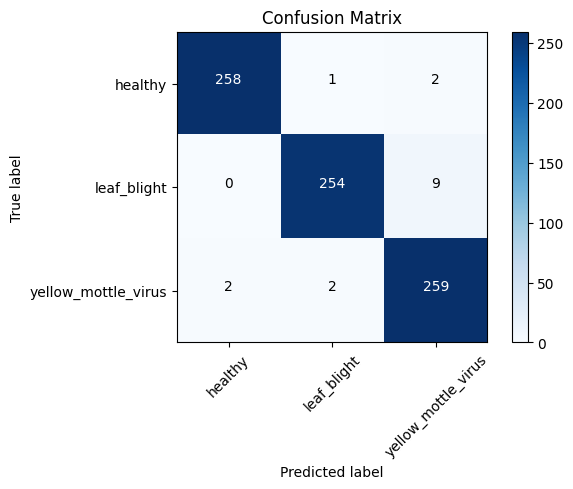

In [29]:
cm_plot_labels=['healthy', 'leaf_blight', 'yellow_mottle_virus']
plot_confusion_matrix(cm=cm, classes=cm_plot_labels, title='Confusion Matrix')

In [30]:
from sklearn.metrics import classification_report

In [31]:
cr = classification_report(y_true=test_batches.classes, y_pred=rounded_predictions, target_names=cm_plot_labels)
print(cr)

                     precision    recall  f1-score   support

            healthy       0.99      0.99      0.99       261
        leaf_blight       0.99      0.97      0.98       263
yellow_mottle_virus       0.96      0.98      0.97       263

           accuracy                           0.98       787
          macro avg       0.98      0.98      0.98       787
       weighted avg       0.98      0.98      0.98       787



In [32]:
# Evaluate the model on the test set
loss, accuracy = model.evaluate(test_batches)

print(f"Test Loss: {loss}")
print(f"Test Accuracy: {accuracy}")

25/25 [==============================] - 5s 180ms/step - loss: 0.0744 - accuracy: 0.9797
Test Loss: 0.07441896945238113
Test Accuracy: 0.9796696305274963
